In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from astropy.io import fits
import astropy.units as u
from maplib import load_out3, cumulative_integral

import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm

In [3]:
# Test values
LON = -180.
LAT = 0.
infile = 'Gas_Ext/Phi{:.1f}Theta{:.1f}_dtau_dz.fits'.format(LON, LAT)

## Read in the relevant file and calculate the extinction along the sight line

In [4]:
def read_opac_file(filename):
    hdulist   = fits.open(filename)
    opac_dict = dict()
    for h in hdulist:
        if h.name == 'PRIMARY':
            pass
        else:
            opac_dict[h.name] = h.data
    hdulist.close()
    return opac_dict

In [5]:
def sum_ext(opac_dict, keys=None):
    if keys is None:
        keys = list(opac_dict.keys())
        
    dtau_dz = np.zeros_like(opac_dict[keys[0]])
    for k in keys:
        dtau_dz += opac_dict[k]
    
    return dtau_dz

In [6]:
dtau_dz_g = read_opac_file(infile) # dtau/dz for each gas
dtau_dz   = sum_ext(dtau_dz_g)

In [7]:
thermo = load_out3('thermo', LON, LAT)
z = thermo['z'] # cm

p_unit = u.dyne / u.cm**2
p = thermo['p'] * p_unit.to(u.bar)

wavel = load_out3('wavel', LON, LAT)

Text(0, 0.5, '$d\\tau/dz$ (cm$^{-1}$)')

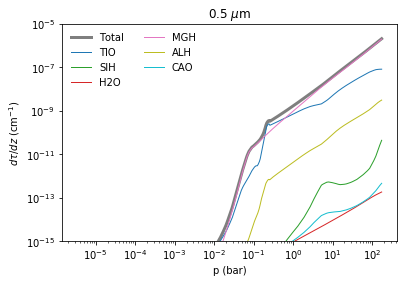

In [8]:
iw   = 2
ylim = (1.e-15, 1.e-5) 
plt.plot(p, dtau_dz[:,iw], color='k', lw=3, alpha=0.5, label='Total')

for k in dtau_dz_g.keys():
    if max(dtau_dz_g[k][:,iw]) > ylim[0]: ll = k
    else: ll = ''
    plt.plot(p, dtau_dz_g[k][:,iw], lw=1, label=ll)

plt.loglog()
plt.ylim(ylim)
plt.legend(loc='upper left', frameon=False, ncol=2)

plt.title('{:.1f} $\mu$m'.format(wavel[iw]))
plt.xlabel('p (bar)')
plt.ylabel(r'$d\tau/dz$ (cm$^{-1}$)')

In [9]:
# Important gases, based on above plot
IMPGAS = ['TIO', 'SIO', 'SIH', 'H2O', 'H2', 'H2S', 'MGH', 'FEH', 'ALH', 'CAO', 'CAH', 'C2H2', 'CH4']

In [10]:
ci = cumulative_integral(z, dtau_dz)

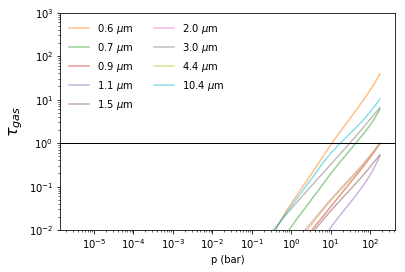

In [11]:
for i in range(len(wavel))[::3]:
    if max(ci[:,i]) > 1.e-2: ll = '{:.1f} $\mu$m'.format(wavel[i])
    else: ll = ''
    _ = plt.plot(p, ci[:,i], alpha=0.5, label=ll)

_ = plt.axhline(1.0, color='k', lw=1)

plt.loglog()
plt.ylim(1.e-2, 1.e3)

plt.xlabel('p (bar)')
plt.ylabel(r'$\tau_{gas}$', size=16)
plt.legend(loc='upper left', frameon=False, ncol=2)

In [12]:
def atmosphere_depth(lon, lat, tau=1.0, keys=None):
    infile = 'Gas_Ext/Phi{:.1f}Theta{:.1f}_dtau_dz.fits'.format(lon, lat)
    dtau_dz_g = read_opac_file(infile) # dtau/dz for each gas
    dtau_dz   = sum_ext(dtau_dz_g, keys=keys)
    
    thermo = load_out3('thermo', lon, lat)
    z = thermo['z'] # cm
    p_unit = u.dyne / u.cm**2
    p = thermo['p'] * p_unit.to(u.bar)
    wavel = load_out3('wavel', lon, lat)
    
    ci = cumulative_integral(z, dtau_dz)
    result = []
    for i in range(len(wavel)):
        result.append(np.interp(tau, ci[:,i], p))
    return result

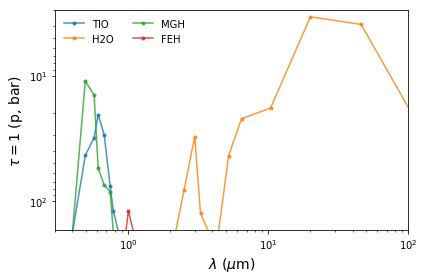

In [13]:
from scipy.interpolate import CubicSpline, spline

def smooth_curve(w, t, nx=100):    
    new_x = np.logspace(np.log10(w[0]), np.log10(w[-1]), nx)
    #cs = CubicSpline(w, t)
    #return new_x, cs(new_x)
    new_y = spline(w, t, new_x, order=1)
    return new_x, new_y

#atm_depth = atmosphere_depth(-90, LAT)
#plt.plot(wavel, atm_depth, alpha=0.5, lw=3, color='k', label='sum')

lon, lat = -90., 0.
for k in dtau_dz_g.keys():
    atm_depth = atmosphere_depth(lon, lat, keys=[k])
    if np.min(atm_depth) < 150.:
        plt.plot(wavel, atm_depth, alpha=0.8, marker='.', label=k)
        #x, y = smooth_curve(wavel, atm_depth)
        #plt.plot(x, y, alpha=0.8, label=k)

'''for k in dtau_dz_g.keys():
    atm_depth = atmosphere_depth(lon, lat, keys=[k], tau=0.1)
    if np.min(atm_depth) < 150.:
        plt.plot(wavel, atm_depth, alpha=0.8, marker='.', ls='--', label=k)
        #x, y = smooth_curve(wavel, atm_depth)
        #plt.plot(x, y, alpha=0.8, label=k)'''

plt.loglog()
plt.xlabel(r'$\lambda$ ($\mu$m)', size=14)
plt.ylabel(r'$\tau=1$ (p, bar)', size=14)
plt.ylim(170., 3.0)
plt.xlim(0.3, 100.0)
plt.legend(loc='upper left',frameon=False, ncol=2)
plt.tight_layout()
plt.savefig('gas_opacity_wavel.pdf', format='pdf')

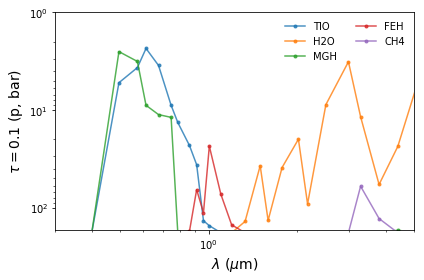

In [23]:
lon, lat = -90., 0.
for k in dtau_dz_g.keys():
    atm_depth = atmosphere_depth(lon, lat, keys=[k], tau=0.1)
    if np.min(atm_depth) < 150. and np.min(wavel[np.array(atm_depth) < 150]) < 5.0:
        plt.plot(wavel, atm_depth, alpha=0.8, marker='.', label=k)
        #x, y = smooth_curve(wavel, atm_depth)
        #plt.plot(x, y, alpha=0.8, label=k)

plt.loglog()
plt.xlabel(r'$\lambda$ ($\mu$m)', size=14)
plt.ylabel(r'$\tau=0.1$ (p, bar)', size=14)
plt.ylim(170., 1.0)
plt.xlim(0.3, 5.0)
plt.legend(loc='upper right',frameon=False, ncol=2)
plt.tight_layout()
plt.savefig('gas_opacity_10pc_wavel.pdf', format='pdf')

## Make a function for producing the map

In [15]:
lons  = np.arange(-180., 180.01, 15) # deg
lats  = np.arange(0., 67.51, 22.5) # deg
nprof = len(lons) * len(lats) # number of (lon, lat) profiles

NLO, NLA, NWA = len(lons), len(lats), len(wavel)
Z = np.zeros((NLO, NLA, NWA))
for i in range(NLO):
    for j in range(NLA):
        d = atmosphere_depth(lons[i], lats[j], tau=1.0) # bar
        Z[i,j,:] = d

(200.0, 0.1)

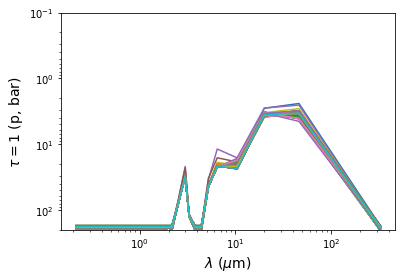

In [16]:
# Check how much the curves change across the regions
for i in lons:
    for j in lats:
        ad = atmosphere_depth(i, j, keys=['H2O'])
        plt.plot(wavel, ad)

plt.loglog()
plt.xlabel(r'$\lambda$ ($\mu$m)', size=14)
plt.ylabel(r'$\tau=1$ (p, bar)', size=14)
plt.ylim(200., 0.1)

In [24]:
# Mesh grid to use for the map
X, Y = np.meshgrid(lons,lats)

# Default contour levels to use
nlev = 21
log_pmin, log_pmax = 0.0, 2.0
lev  = np.linspace(log_pmin, log_pmax, nlev)

In [28]:
def map_gas_depth(i, levels=lev, cmap=plt.cm.RdYlBu_r):
    m        = Basemap(projection='kav7', lon_0=0, resolution=None)
    CS_north = m.contourf(X, Y, np.log10(Z[:,:,i].T),
                          levels=levels, extend='both', cmap=cmap, latlon=True)
    CS_south = m.contourf(X, -Y, np.log10(Z[:,:,i].T),
                          levels=levels, extend='both', cmap=cmap, latlon=True)
    
    plt.colorbar(label=r'$\tau(\lambda) = 1$ [log bar]',
                 #ticks=np.arange(log_pmin+1, log_pmax+1)[::2],
                 orientation='horizontal')
    plt.title('{:.2f} $\mu$m'.format(wavel[i]))
    
    ## -- Plot lat-lon lines on map
    # String formatting function
    def fmtfunc(inlon):
        string = r'{:g}'.format(inlon)+r'$^{\circ}$'
        #print string
        return string

    meridians = np.arange(0., 360., 90)
    m.drawmeridians(meridians, labels=[False,False,False,True],
                    labelstyle=None, fmt=fmtfunc, dashes=[3,3], color='k', fontsize=14)
    parallels = np.arange(-90., 90, 30)
    m.drawparallels(parallels, labels=[True,False,False,False],
                    labelstyle='+/-', dashes=[3,3], color='k',fontsize=14)

    # and we're done!
    return CS_north

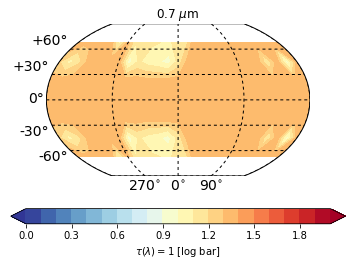

In [26]:
map_gas_depth(5)

## Make a widget to view different wavelength maps

In [20]:
import ipywidgets as widgets
from ipywidgets import interact

In [21]:
def widget_map(i):
    result = map_gas_depth(i)
    return

In [29]:
w = widgets.IntSlider(10, min=0, max=len(wavel)-1, continuous_update=False)
interact(widget_map, i=w)

interactive(children=(IntSlider(value=10, continuous_update=False, description='i', max=30), Output()), _dom_c…

<function __main__.widget_map(i)>

In [30]:
print(dtau_dz_g.keys())

dict_keys(['TIO', 'SIO', 'SIH', 'H2O', 'H2', 'H2S', 'MGH', 'FEH', 'ALH', 'CAO', 'CAH', 'C2H2', 'CH4'])
